<a href="https://colab.research.google.com/github/josephmhernandez/SeizureDetection/blob/master/Model2_Seizure_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#To run this demo: 
# 1. Upload model rnn2-improvement-29-100.hdf5
# 2. run the !pip install block so that the model can be extracted correctly from the file
# 3. Run the next two code blocks (openPose and using the model to predict.)
#
#

In [0]:
#  Upload model rnn2-improvement-29-100.hdf5
from google.colab import files
src = list(files.upload().values())[0]

In [0]:
!pip install --upgrade pip setuptools wheel
!pip install -I tensorflow
!pip install -I keras

In [0]:
#Input Data. 

#These are public videos to whoever has the link. 

# Test-vid-4-hd : https://www.youtube.com/watch?v=_Cybo4bEWPs
# Test-vid-5-hd : https://www.youtube.com/watch?v=Fz6vWTFux8o
# Test-vid-6-hd : https://www.youtube.com/watch?v=XQbGXOXaEl0
# Test-vid-7-hd : https://www.youtube.com/watch?v=pyHrRS7ND28
# Test-vid-8-hd : https://www.youtube.com/watch?v=1VH-f8kVy6k

link_video = 'https://www.youtube.com/watch?v=XQbGXOXaEl0'
 

In [14]:
!pip install youtube_dl
!pip install pafy

#Load Open Pose
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`


#Function: save video in colab memory 
!pip install youtube_dl
!pip install pafy

import youtube_dl
import os
import pafy
import numpy as np

def create_vid(link):
    ydl = youtube_dl.YoutubeDL({'outtmpl': '%(id)s%(ext)s',
            'noplaylist' : True})
    link_video = link
    with ydl:
        result = ydl.extract_info(
            link_video,
            download=True
        )

    if 'entries' in result:
        # Can be a playlist or a list of videos
        video = result['entries'][0]
    else:
        # Just a video
        video = result

    # print(video)
    title = video['id']

    file_list = np.array(os.listdir(path=None))
    video_name = None
    # print(file_list)
    for a in file_list:
        if(title in a):
            print('here')
            video_name = a
            break

    nvideo = pafy.new(link_video)
    video_duration=nvideo.length 

    os.rename(video_name, nvideo.title + '.' + video['ext'])
    video_name = nvideo.title + '.' + video['ext']
    title = nvideo.title
    return video_name, title

# Function
# Iterate through JSON files of a video and save every 120 as an npy file. 
import json
import numpy as np
import os
def create_120_npy_from_vid_json(read_json_folder, write_folder, save_name):
    newJsonOutput = read_json_folder
    # newJsonOutput = 'gdrive/My Drive/Seizure2/T10_ks3_hd/'
    print('Change JSON files to npy files....')
    jsonFiles = np.array(os.listdir(newJsonOutput))
    jsonFiles.sort()

    rtnList = np.zeros((len(jsonFiles),50)) 

    # print(jsonFiles[:7])
    print('THIS ONE RIGHT HERE.>')
    print(len(jsonFiles))
    # print('total npy outputs: ' + str(len(jsonFiles) // 120))

    for i,jsonFile in enumerate(jsonFiles): 
        if (i % 1000 == 0): print('\tupdate:' + str(i))
        with open(newJsonOutput + '/' + jsonFiles[i]) as jsonOutput:
            data = json.load(jsonOutput)
            try:
                bodyLandmarks = data['people'][0]['pose_keypoints_2d']    
                #Get rid of the confidence of points
                bodyLandmarks = [xx for p, xx in enumerate(bodyLandmarks) if p%3 !=2]
                # print(bodyLandmarks)
                #Y - coordinates are opposite. Makes printing out coordinates easier to visualize. 
                for inc in range(len(bodyLandmarks)):
                    if inc % 2 == 1:
                        bodyLandmarks[inc] = 1 - bodyLandmarks[inc]
                
                rtnList[i,] = bodyLandmarks
            except:
                print('oof.' + str(i))
                # print(data)
                continue

    # !mkdir {write_npy_files}
    np.save(write_folder+save_name+'.npy', rtnList)
    # print('write_npys')
    # _count_id = 1

    # for j in range(120, len(rtnList), 120):
    #     _temp_data = rtnList[j-120:j]
    #     np.save(write_folder + save_name + '_' + str(_count_id) + '.npy', _temp_data)
    #     _count_id += 1
    
    print('finished')


# Generate OpenPose Outputs 

_name, title = create_vid(link_video)
json_output = '/content/temp'+title +'/'

newvidInput = _name

train_folder = '/content/'


print(_name)
newJsonOutput = json_output
py_json_folder = json_output
!./openpose/build/examples/openpose/openpose.bin --tracking 10 --render_pose 0 --video {newvidInput} --write_json {newJsonOutput} --model_folder openpose/models --disable_blending --display 0 --number_people_max 1 --scale_number 4 --scale_gap 0.25 --keypoint_scale 3

write_npy_files = train_folder

# !mkdir gdrive/My\ Drive/Seizure2/all_data_hd_npy/

create_120_npy_from_vid_json(read_json_folder=py_json_folder, write_folder=write_npy_files, save_name=title)


#Delete json folder
!rm -rf {newJsonOutput}
#Delete video 
!rm -f {newvidInput}


[youtube] XQbGXOXaEl0: Downloading webpage
[youtube] Downloading just video XQbGXOXaEl0 because of --no-playlist
[youtube] XQbGXOXaEl0: Downloading MPD manifest


[dashsegments] Total fragments: 9
[download] Destination: XQbGXOXaEl0webm.f247
[download] 100% of 4.13MiB in 00:02
[dashsegments] Total fragments: 5
[download] Destination: XQbGXOXaEl0m4a.f140
[download] 100% of 618.21KiB in 00:00
[ffmpeg] Merging formats into "XQbGXOXaEl0webm.mkv"
Deleting original file XQbGXOXaEl0webm.f247 (pass -k to keep)
Deleting original file XQbGXOXaEl0m4a.f140 (pass -k to keep)
here
Test-vid-6-hd.webm
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Person tracking (`tracking` flag) is in experimental phase. Please, let us know if you find any bug on this alpha version.
Empty frame detected, frame number 1170 of 1172. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 1170 of 1172. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, 

Open this file /content/Test-vid-6-hd.npy
Data: Test-vid-6-hd
frames?: 1170
nope
nope
nope
nope


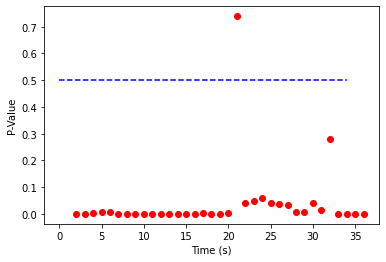

In [15]:
#Load model. 
from keras.models import load_model
import numpy as np
import os
import json 
#Define function to give us list inputs from 120,50 data:
def slice_data(opened_data):
    _temp_r_arm_data = np.empty((120,6))
    _temp_l_arm_data = np.empty((120,6))
    _temp_r_leg_data = np.empty((120, 12))
    _temp_l_leg_data = np.empty((120, 12))
    _temp_torso_data = np.empty((120, 12))

    for j,mat in enumerate(opened_data):
        #iterate 120 timestamps
        mult = 2
        #(120, 6) pad with 6 zeros 
        _temp_r_arm_data[j,] = np.array([mat[2*mult], mat[mult*2+1], 
                                    mat[3*mult], mat[mult*3+1],
                                    mat[4*mult], mat[mult*4+1]])
        
        #(120, 6) pad with 6 zeros
        _temp_l_arm_data[j,] = np.array([mat[5*mult], mat[mult*5+1], 
                                    mat[6*mult], mat[mult*6+1],
                                    mat[7*mult], mat[mult*7+1]])
        
        #(120, 12)
        _temp_r_leg_data[j,] = np.array([mat[9*mult], mat[mult*9+1], 
                                    mat[10*mult], mat[mult*10+1],
                                    mat[11*mult], mat[mult*11+1],
                                    mat[22*mult], mat[mult*22+1], 
                                    mat[23*mult], mat[mult*23+1],
                                    mat[24*mult], mat[mult*24+1]])
        #(120, 12)
        _temp_l_leg_data[j,] = np.array([mat[12*mult], mat[mult*12+1], 
                                    mat[13*mult], mat[mult*13+1],
                                    mat[14*mult], mat[mult*14+1],
                                    mat[19*mult], mat[mult*19+1], 
                                    mat[20*mult], mat[mult*20+1],
                                    mat[21*mult], mat[mult*21+1]]) 
        
        #(120, 12)
        _temp_torso_data[j,] = np.array([mat[1*mult], mat[mult*1+1], 
                                    mat[2*mult], mat[mult*2+1],
                                    mat[5*mult], mat[mult*5+1],
                                    mat[8*mult], mat[mult*8+1], 
                                    mat[9*mult], mat[mult*9+1],
                                    mat[12*mult], mat[mult*12+1]])
    
    return [_temp_torso_data.reshape(1,120,12), _temp_l_arm_data.reshape(1,120,6), _temp_r_arm_data.reshape(1,120,6), _temp_l_leg_data.reshape(1,120,12), _temp_r_leg_data.reshape(1,120,12)]

model_path = 'rnn2-improvement-29-100.hdf5'
my_model = load_model(model_path)


data = np.load(write_npy_files + title + '.npy')
print('Open this file ' + write_npy_files + title + '.npy')
# data = np.load('Test-vid-1-hd.npy')
print('Data: ' + title)
# seconds = video_duration


frames = len(data)
print('frames?:', frames)
fps = 30



pred_data = [] #[ [timestamp (s) , p-value], ... ]
time_vals = []
pred_vals = []
for t in range(0, frames//fps):
    _curr_frame = round(t * fps)
    if ((_curr_frame - 60) < 0) or (_curr_frame + 60 > frames - 1):
        print('nope')
        # pred_data.append([t,0])
        # time_vals.append(t)
        # pred_vals.append(0)
    else:
        _use = data[_curr_frame - 60 : _curr_frame + 60,]
        

        real_x = slice_data(_use)
        

        _pval = float(my_model.predict(x=real_x))
        pred_data.append([t,_pval])
        time_vals.append(t)

        pred_vals.append(_pval)

#Plot results.
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time_vals, pred_vals, 'ro')
plt.xlabel('Time (s)')
plt.ylabel('P-Value')
plt.plot(range(len(time_vals)), [.5 for x in range(len(time_vals))], 'b--')
plt.savefig(title + '.png')

plt.show()

my_dict = {}
my_dict['seizure'] = pred_data
import json
with open(title + '.json', 'w') as fp:
    json.dump(my_dict, fp)